# Analysing pore dimensions with HOLE2

Here we use `HOLE` to analyse pore dimensions in a membrane.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [HOLE](http://www.holeprogram.org)
* matplotlib
* numpy

<div class="alert alert-info">
    
**Note**

The classes in `MDAnalysis.analysis.hole2` are wrappers around the HOLE program. Please cite (<a data-cite="smart_pore_1993" href="https://doi.org/10.1016/S0006-3495(93)81293-1">Smart *et al.*, 1993</a>, <a data-cite="smart_hole_1996" href="https://doi.org/10.1016/s0263-7855(97)00009-x">Smart *et al.*, 1996</a>) when using this module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_HOLE
from MDAnalysis.analysis import hole2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import warnings
# suppress some MDAnalysis warnings when writing PDB files
warnings.filterwarnings('ignore')

## Background

The `MDAnalysis.analysis.hole2` module ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/hole2.html)) provides wrapper classes and functions that call the [HOLE](http://www.holeprogram.org) program. This means you must have installed the program yourself before you can use the class. You then have 2 options, you either pass the path to your ``hole`` executable to the class; in this example, ``hole`` is installed at ``~/hole2/exe/hole``. Or, set your binary path variable (``$PATH`` in Unix systems) to point to the executable's folder so you don't have to point to the binary explicitly every time you call ``hole`` or any of its helper tools. This is what we have done here, so we don't have to set the `executable` argument.

HOLE defines a series of points throughout the pore from which a sphere can be generated that does not overlap any atom (as defined by its van der Waals radius). (Please see (<a data-cite="smart_pore_1993" href="https://doi.org/10.1016/S0006-3495(93)81293-1">Smart *et al.*, 1993</a>, <a data-cite="smart_hole_1996" href="https://doi.org/10.1016/s0263-7855(97)00009-x">Smart *et al.*, 1996</a>) for a complete explanation). By default, it ignores residues with the following names: "SOL", "WAT", "TIP", "HOH", "K  ", "NA ", "CL ". You can change these with the ``ignore_residues`` keyword. Note that the residue names must have 3 characters. Wildcards *do not* work.

This tutorial first demonstrates how to use the ``MDAnalysis.analysis.hole2.hole`` function similarly to [the HOLE binary on a PDB file](#Using-HOLE-with-a-PDB-file). We then demonstrate how to use the ``MDAnalysis.analysis.hole2.HoleAnalysis`` class on a [trajectory of data](#Using-HOLE-with-a-trajectory). You may prefer to use the more fully-featured ``HoleAnalysis`` class for the extra functionality we provide, such as creating an animation in VMD of the pore.

## Using HOLE with a PDB file 

The `hole` function allows you to specify points to begin searching at (`cpoint`) and a search direction (`cvect`), the sampling resolution (`sample`), and more. Please see the documentation for full details.

The PDB file here is the experimental structure of the Gramicidin A channel. Note that we pass `HOLE` a PDB file directly, without creating a `MDAnalysis.Universe`.

We are setting a `random_seed` here so that the results in the tutorial can be reproducible. This is normally not advised.

In [2]:
profiles = hole2.hole(PDB_HOLE, 
                      outfile='hole1.out',
                      sphpdb_file='hole1.sph',
                      vdwradii_file=None,
                      random_seed=31415,
                      #   executable='~/hole2/exe/hole',
                      )

`outfile` and `sphpdb_file` are the names of the files that HOLE will write out. `vdwradii_file` is a file of necessary van der Waals' radii in a HOLE-readable format. If set to ``None``, MDAnalysis will create a `simple2.rad` file with the built-in radii from the HOLE distribution.

This will create several outputs in your directory:

 - **hole1.out**: the log file for HOLE. 
 - **hole1.sph**: a PDB-like file containing the coordinates of the pore centers.
 - **simple2.rad**: file of Van der Waals' radii
 - **tmp/pdb_name.pdb**: the short name of a PDB file with your structure. As `hole` is a FORTRAN77 program, it is limited in how long of a filename that it can read. Symlinking the file to the current directory can shorten the path.
 
If you do not want to keep the files, set `keep_files=False`. Keep in mind that you will not be able to create a VMD surface without the sphpdb file.
 
The pore profile itself is in the `profiles1` dictionary, indexed by frame. There is only one frame in this PDB file, so it is at `profiles1[0]`.

In [3]:
profiles[0].shape

(425,)

Each profile is a ``numpy.recarray`` with the fields below as an entry for each `rxncoord`: 

  - **rxn_coord**: the distance along the pore axis in angstrom
  - **radius**: the pore radius in angstrom
  - **cen_line_D**: distance measured along the pore centre line - the first point found is set to zero.

In [4]:
profiles[0].dtype.names

('rxn_coord', 'radius', 'cen_line_D')

You can then proceed with your own analysis of the profiles. 

In [5]:
rxn_coords = profiles[0].rxn_coord
pore_length = rxn_coords[-1] - rxn_coords[0]
print('The pore is {} angstroms long'.format(pore_length))

The pore is 42.4 angstroms long


You can create a VMD surface from the `hole1.sph` output file, using the `create_vmd_surface` function.

In [6]:
hole2.create_vmd_surface(filename='hole1.vmd',
                         sphpdb='hole1.sph',
                        #  sph_process='~/hole2/exe/sph_process',
                         )

'hole1.vmd'

To view this, open your PDB file in VMD.

`vmd tmp*/*.pdb`

Load the output file in Extensions > Tk Console:

`source hole1.vmd`

Your pore surface will be drawn as below.

<center>
<div style="width:200px; text-align:center;">

![sphpdb.png](sphpdb.png)
    
</div>
</center>

MDAnalysis supports many of the options that can be customised in HOLE. For example, you can specify a starting point for the pore search within the pore with `cpoint`, and a ``sample`` distance (default: 0.2 angstrom) for the distance between the planes used in HOLE. Please see the [MDAnalysis.analysis.hole2](https://www.mdanalysis.org/docs/documentation_pages/analysis/hole2.html) for more information.

## Using HOLE with a trajectory

One of the limitations of the ``hole`` program is that it can only accept PDB files. In order to use other formats with ``hole``, or to run ``hole`` on trajectories, we can use the ``hole2.HoleAnalysis`` class with an ``MDAnalysis.Universe``. While the example file below is a PDB, you can use any files to create your Universe. You can also specify that the HOLE analysis is only run on a particular group of atoms with the `select` keyword (default value: 'protein').

As with `hole()`, `HoleAnalysis` allows you to select a starting point for the search (`cpoint`). You can pass in a coordinate array; alternatively, you can use the center-of-geometry of your atom selection in each frame as the start.

In [7]:
from MDAnalysis.tests.datafiles import MULTIPDB_HOLE

u = mda.Universe(MULTIPDB_HOLE)

ha = hole2.HoleAnalysis(u, select='protein',
                        cpoint='center_of_geometry',
                        # executable='~/hole2/exe/hole',
                        )
ha.run(random_seed=31415)

### Working with the data

Again, the data is stored in `ha.results.profiles` as a dictionary of `numpy.recarray`s. The dictionary is indexed by frame; we can see the HOLE profile for the fourth frame below (truncated to the first 10 values).

In [8]:
for rxn_coord, radius, cen_line_D in (ha.results.profiles[3][:10]):
    print(f"{rxn_coord:.2f}, {radius:.2f}, {cen_line_D:.2f}")

-21.01, 15.35, -39.24
-20.91, 12.63, -34.65
-20.81, 10.64, -30.05
-20.71, 9.58, -27.73
-20.61, 8.87, -25.40
-20.51, 8.57, -23.62
-20.41, 8.56, -21.84
-20.31, 8.48, -21.74
-20.21, 8.39, -21.64
-20.11, 8.30, -21.54


If you want to collect each individual property, use `gather()`. Setting `flat=True` flattens the lists of `rxn_coord`, `radius`, and `cen_line_D`, in order. You can select which frames you want by passing an iterable of frame indices to `frames`. `frames=None` returns all frames.

In [9]:
gathered = ha.gather()
print(gathered.keys())

dict_keys(['rxn_coord', 'radius', 'cen_line_D'])


In [10]:
print(len(gathered['rxn_coord']))

11


In [11]:
flat = ha.gather(flat=True)
print(len(flat['rxn_coord']))

3967


You may also want to collect the radii in bins of `rxn_coord` for the entire trajectory with the `bin_radii()` function. `range` should be a tuple of the lower and upper edges of the first and last bins, respectively. If `range=None`, the minimum and maximum values of `rxn_coord` are used.

`bins` can be either an iterable of (lower, upper) edges (in which case `range` is ignored), or a number specifying how many bins to create with `range`.

In [12]:
radii, edges = ha.bin_radii(bins=100, range=None)

The closely related `histogram_radii()` function takes the same arguments as `bin_radii()` to group the pore radii, but allows you to specify an aggregating function with `aggregator` (default: `np.mean`) that will be applied to each array of radii. The arguments for this function, and returned values, are analogous to those for `np.histogram`. 

In [13]:
means, edges = ha.histogram_radii(bins=100, range=None,
                                  aggregator=np.mean)

We can use this to plot the mean radii of the pore over the trajectory. (You can also accomplish this with the `plot_mean_profile()` function shown below, by setting `n_std=0`.)

Text(0.5, 0, 'Pore coordinate $\\zeta$ ($\\AA$)')

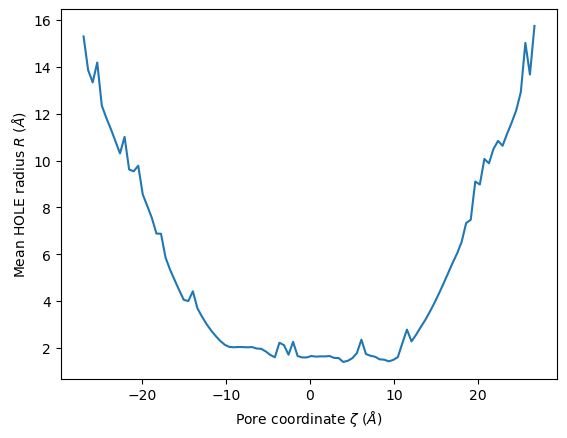

In [14]:
midpoints = 0.5*(edges[1:]+edges[:-1])
plt.plot(midpoints, means)
plt.ylabel(r"Mean HOLE radius $R$ ($\AA$)")
plt.xlabel(r"Pore coordinate $\zeta$ ($\AA$)")

`HoleAnalysis` also has the `min_radius()` function, which will return the minimum radius in angstrom for each frame. The resulting array has the shape (#n_frames, 2).

In [15]:
min_radii = ha.min_radius()
for frame, min_radius in min_radii:
    print(f"Frame {int(frame)}: {min_radius:.3f}")

Frame 0: -0.237
Frame 1: 1.567
Frame 2: 1.533
Frame 3: 1.425
Frame 4: 1.243
Frame 5: 1.198
Frame 6: 1.296
Frame 7: 1.438
Frame 8: 1.511
Frame 9: 0.879
Frame 10: 0.997


Text(0.5, 0, 'Frame')

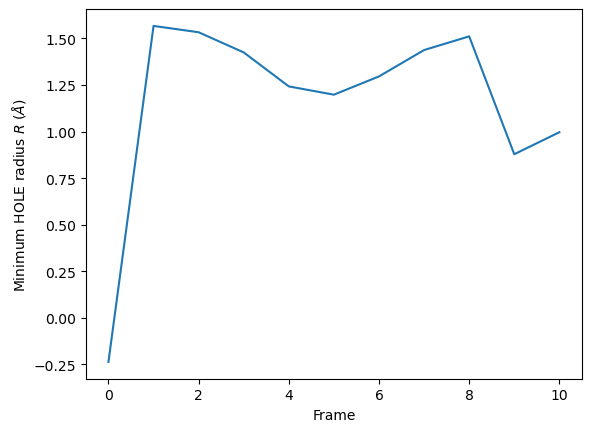

In [16]:
plt.plot(min_radii[:, 0], min_radii[:, 1])
plt.ylabel('Minimum HOLE radius $R$ ($\AA$)')
plt.xlabel('Frame')

### Visualising the VMD surface

The `create_vmd_surface()` method is built into the `HoleAnalysis` class. It writes a VMD file that changes the pore surface for each frame in VMD. Again, load your file and source the file in the Tk Console:

`source holeanalysis.vmd`

In [17]:
ha.create_vmd_surface(filename='holeanalysis.vmd')

'holeanalysis.vmd'


<center>
<div style='width: 300px'>
    
![hole.gif](pore.gif)
    
</div>
</center>

### Plotting

`HoleAnalysis` has several convenience methods for plotting. `plot()` plots the HOLE radius over each pore coordinate, differentiating each frame with colour.

<AxesSubplot: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='HOLE radius $R$ ($\\AA$)'>

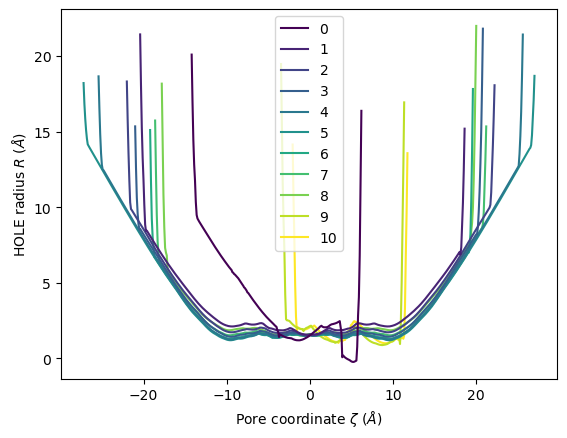

In [18]:
ha.plot()

You can choose to plot specific frames, or specify colours or a colour map. Please see the documentation for a full description of arguments.

<AxesSubplot: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='HOLE radius $R$ ($\\AA$)'>

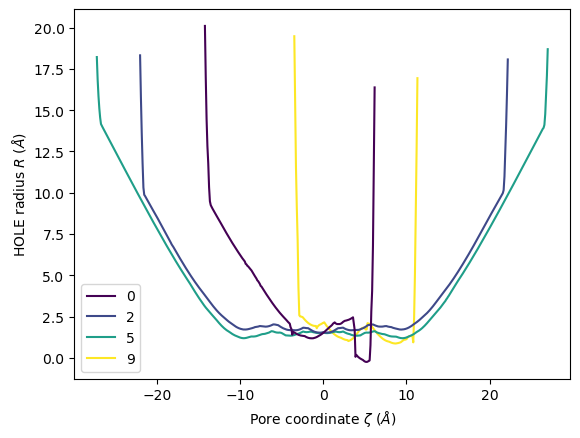

In [19]:
ha.plot(frames=[0, 2, 5, 9])

The `plot3D()` function separates each frame onto its own axis in a 3D plot.

<Axes3DSubplot: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='Frames', zlabel='HOLE radius $R$ ($\\AA$)'>

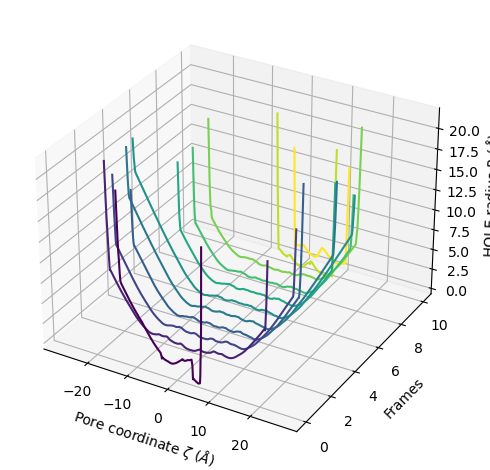

In [20]:
ha.plot3D()

You can choose to plot only the part of each pore lower than a certain radius by setting `r_max`.

<Axes3DSubplot: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='Frames', zlabel='HOLE radius $R$ ($\\AA$)'>

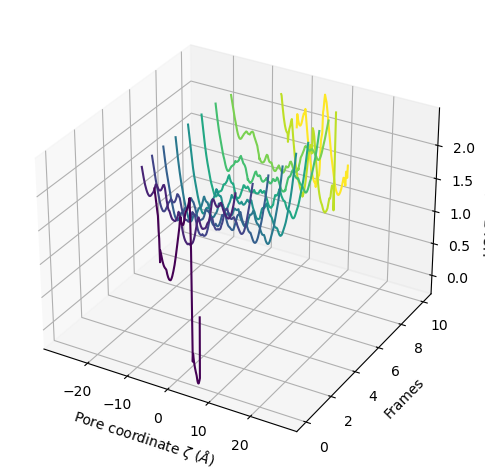

In [21]:
ha.plot3D(r_max=2.5)

You can also plot the mean and standard deviation of the pore radius over the pore coordinate.

<AxesSubplot: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='HOLE radius $R$ ($\\AA$)'>

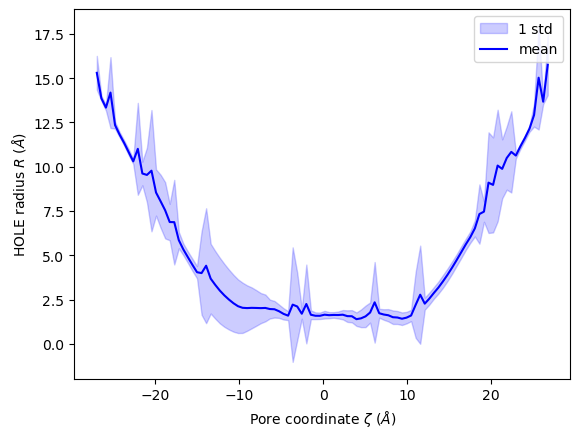

In [22]:
ha.plot_mean_profile(bins=100,  # how much to chunk rxn_coord
                     n_std=1,  # how many standard deviations from mean
                     color='blue',  # color of plot
                     fill_alpha=0.2,  # opacity of standard deviation
                     legend=True)

## Ordering HOLE profiles with an order parameter

If you are interested in the HOLE profiles over an order parameter, you can directly pass that into the analysis after it is run. Below, we use an order parameter of RMSD from a reference structure.

<div class="alert alert-info">
    
**Note**

Please cite (<a data-cite="stelzl_flexible_2014" href="https://doi.org/10.1016/j.jmb.2013.10.024">Stelzl *et al.*, 2014</a>) when using the ``over_order_parameters`` functionality.

</div>

In [23]:
from MDAnalysis.analysis import rms

ref = mda.Universe(PDB_HOLE)
rmsd = rms.RMSD(u, ref, select='protein', weights='mass').run()
rmsd_values = rmsd.rmsd[:, 2]
for i, rmsd in enumerate(rmsd_values):
    print(f"Frame {i}:  {rmsd:.2f}")

Frame 0:  6.11
Frame 1:  4.88
Frame 2:  3.66
Frame 3:  2.44
Frame 4:  1.22
Frame 5:  0.00
Frame 6:  1.22
Frame 7:  2.44
Frame 8:  3.66
Frame 9:  4.88
Frame 10:  6.11


You can pass this in as `order_parameter`. The resulting `profiles` dictionary will have your order parameters as keys. **You should be careful with this if your order parameter has repeated values, as duplicate keys are not possible; each duplicate key just overwrites the previous value.**

In [24]:
op_profiles = ha.over_order_parameters(rmsd_values)

You can see here that the dictionary does not order the entries by the order parameter. If you iterate over the dictionary, it will return each (key, value) pair in sorted key order.

In [25]:
for order_parameter, profile in op_profiles.items():
    print(f"{order_parameter:.3f}, {len(profile)}")

0.000, 543
1.221, 389
1.221, 511
2.442, 419
2.442, 399
3.663, 379
3.663, 443
4.884, 391
4.884, 149
6.105, 205
6.105, 139


You can also select specific frames for the new profiles.

In [26]:
op_profiles = ha.over_order_parameters(rmsd_values, frames=[0, 4, 9])
for order_parameter, profile in op_profiles.items():
    print(f"{order_parameter:.3f}, {len(profile)}")

1.221, 511
4.884, 149
6.105, 205


### Plotting

`HoleAnalysis` also provides convenience functions for plotting over order parameters. Unlike `plot()`, `plot_order_parameters()` requires an ``aggregator`` function that reduces an array of radii to a singular value. The default function is ``min()``. You can also pass in functions such as ``max()`` or ``np.mean()``, or define your own function to operate on an array and return a vlue.

<AxesSubplot: xlabel='RMSD to reference ($\\AA$)', ylabel='Minimum HOLE pore radius $r$ ($\\AA$)'>

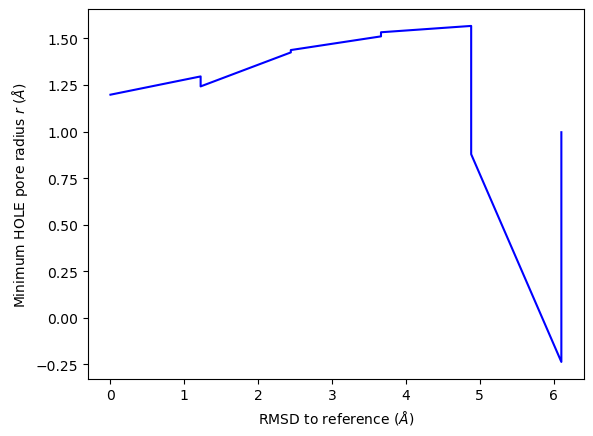

In [27]:
ha.plot_order_parameters(rmsd_values,
                         aggregator=min,
                         xlabel='RMSD to reference ($\AA$)',
                         ylabel='Minimum HOLE pore radius $r$ ($\AA$)')

`plot3D_order_parameters()` functions in a similar way to `plot3D()`, although you need to pass in the order parameters.

<Axes3DSubplot: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='RMSD to reference ($\\AA$)', zlabel='HOLE radius $R$ ($\\AA$)'>

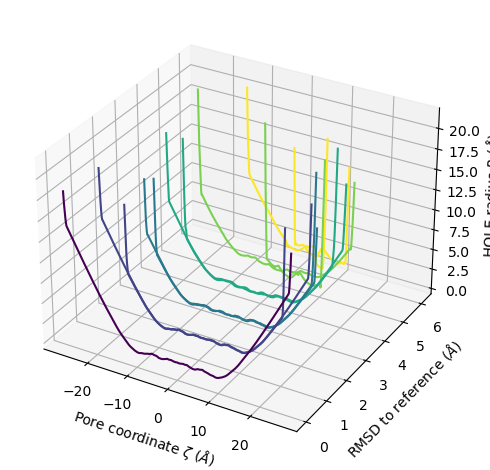

In [28]:
ha.plot3D_order_parameters(rmsd_values,
                           ylabel='RMSD to reference ($\AA$)')

## Deleting HOLE files

The HOLE program and related MDAnalysis code write a number of files out. Both the `hole()` function and `HoleAnalysis` class contain ways to easily remove these files.

For `hole()`, pass in `keep_files=False` to delete HOLE files as soon as the analysis is done. However, this will also remove the sphpdb file required to create a VMD surface from the analysis. If you need to write a VMD surface file, use the `HoleAnalysis` class instead. 

You can track the created files at the `tmp_files` attribute.

In [29]:
ha.tmp_files

['simple2.rad',
 'hole000.out',
 'hole000.sph',
 'hole001.out',
 'hole001.sph',
 'hole002.out',
 'hole002.sph',
 'hole003.out',
 'hole003.sph',
 'hole004.out',
 'hole004.sph',
 'hole005.out',
 'hole005.sph',
 'hole006.out',
 'hole006.sph',
 'hole007.out',
 'hole007.sph',
 'hole008.out',
 'hole008.sph',
 'hole009.out',
 'hole009.sph',
 'hole010.out',
 'hole010.sph']

The built-in method `delete_temporary_files()` will remove these.

In [30]:
ha.delete_temporary_files()
ha.tmp_files

[]

Alternatively, you can use `HoleAnalysis` as a context manager. When you exit the block, the temporary files will be deleted automatically.

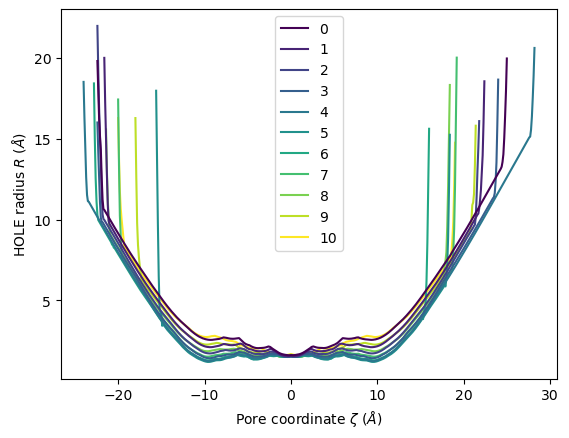

In [31]:
with hole2.HoleAnalysis(u,
    # executable='~/hole2/exe/hole',
    ) as ha2:
    ha2.run()
    ha2.create_vmd_surface(filename='holeanalysis.vmd')
    ha2.plot()

In [32]:
ha.profiles[0][0].radius

20.0962

## References

[1] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[2] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[3] O&nbsp;S Smart, J&nbsp;M Goodfellow, and B&nbsp;A Wallace.
The pore dimensions of gramicidin <span class="bibtex-protected">A</span>.
<em>Biophysical Journal</em>, 65(6):2455–2460, December 1993.
00522.
URL: <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1225986/">https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1225986/</a>, <a href="https://doi.org/10.1016/S0006-3495(93)81293-1">doi:10.1016/S0006-3495(93)81293-1</a>.

[4] O.&nbsp;S. Smart, J.&nbsp;G. Neduvelil, X.&nbsp;Wang, B.&nbsp;A. Wallace, and M.&nbsp;S. Sansom.
<span class="bibtex-protected">HOLE</span>: a program for the analysis of the pore dimensions of ion channel structural models.
<em>Journal of Molecular Graphics</em>, 14(6):354–360, 376, December 1996.
00935.
<a href="https://doi.org/10.1016/s0263-7855(97)00009-x">doi:10.1016/s0263-7855(97)00009-x</a>.

[5] Lukas&nbsp;S. Stelzl, Philip&nbsp;W. Fowler, Mark S.&nbsp;P. Sansom, and Oliver Beckstein.
Flexible gates generate occluded intermediates in the transport cycle of <span class="bibtex-protected">LacY</span>.
<em>Journal of Molecular Biology</em>, 426(3):735–751, February 2014.
00000.
URL: <a href="https://asu.pure.elsevier.com/en/publications/flexible-gates-generate-occluded-intermediates-in-the-transport-c">https://asu.pure.elsevier.com/en/publications/flexible-gates-generate-occluded-intermediates-in-the-transport-c</a>, <a href="https://doi.org/10.1016/j.jmb.2013.10.024">doi:10.1016/j.jmb.2013.10.024</a>.